# **Texture Identification**
MTH2188 Machine Learning Project 1

Simrun Mutha and Melody Chiu

# **Introduction**
Our goal for this project is to implement a convolutional neural network algorithm that can classify different types of textures. Using the PyTorch library, we trained our model on the Describable Textures Dataset from TensorFlow, which contains 120 images for each texture class.

Our algorithm is fairly broad as we are just classifying a random collection of textures.I think our algorithm could be applied to the real world in a variety of more specific scenarios. For example, our model could be used on a dataset of animals and identify the animals based on their spot patterns and fur textures. In the medical field, I think a texture classifier could be useful in dermatology. It could be used to identify different types of rashes, bug bites or skin diseases. II think the model would have to be very accurate to generate value especially in a medical context because a wrong diagnosis could be harmful for people's health. A texture identifier could also be used to detect fabric defects in manufacturing processes. In this situation as well, I think that the model would have to be very accurate because fabric defections are probably very minor and not obvious.


The model we have created more specifically could be used more for recreational purposes just to see how well it classifies textures around us. If the model is not very accurate, there are not many consequences because it is just being used to look at the textures around us. 


In [1]:
!pip install torchviz
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset
from torch.utils.data.sampler import SubsetRandomSampler
from torch.autograd import Variable
from torchviz import make_dot
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
from google.colab.patches import cv2_imshow
import glob
import os
import cv2
import random
import shutil
import time
from PIL import Image

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=f3ef275ef7727107c37b1b970610b2ab4a653cdfedfaef61640d2b6ecb0540e3
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
import zipfile
!unzip /content/drive/MyDrive/images_ml2.zip

# **Data Preprocessing**

To make our dataset easy to access and manipulate through the Google Colab notebook, we uploaded the dataset onto Google Drive as a zip file which we unzip in the notebook during runtime. The first step to preprocessing the data was to resize all the images to be the same size (300x300). To do this, we did two things: expand all the images that are smaller than 300x300, then crop all the images to 300x300. We chose to manipulate our images in this way because the alternative approach, which would be to crop all the images to the size of the smallest image, would cause data loss.

Instead of using the entire TensorFlow textures dataset, we selected 20 texture classes to train our model on. This is because a few of the classes overlap in a way that makes it impossible to train a model on. Certain images correspond to two different texture labels. For example, this image shows a knitted material that has been braided. It’s difficult for even a human to classify this image in either the ‘knitted’ class or the ‘braided’ class!

Other textures simply didn’t have images that looked distinct enough. Some examples include the smeared, freckled, and blotchy texture classes. To avoid confusing data, we specifically selected for textures that had distinctive patterns that a neural network might recognize and that don’t coincide with other textures.

In [4]:
# Function to resize images
def resize_image(im):
  width, height = im.size
  if width < 400 or height < 400:            
    im = im.resize((int(width*1.2), int(height*1.2)))            
    if width < 400 or height< 400:            
      im = im.resize((int(width*1.2), int(height*1.2))) 
      if width < 400 or height:
        im = im.resize((int(width*1.2), int(height*1.2))) 
  return im

In [16]:
# Loop through all images and resize them
for images_path in glob.glob("images_ml2"):
  for folder_path in glob.glob(os.path.join(images_path, '*')):
      for file_path in glob.glob(os.path.join(folder_path, '*.jpg')):        
        file_list = file_path.split("/")
        foldername = file_list[1]
        filename = file_list[2]
        im = Image.open(file_path)
        if im is not None:
            im = resize_image(im)
            save_filename = "/content/" + file_path
            # print(save_filename)
            im.save(save_filename)

# **Image Augmentation**
Next, we artificially create more images by manipulating each image and adding them to the dataset. The three image augmentation techniques we perform are horizontal flipping, vertical flipping and rotation. Increasing the number of images we have helps our model achieve better accuracy because it has more data to train on.

In [17]:
# Create augmented images, add to main images folder
for images_path in glob.glob('images_ml2'):
  for folder_path in glob.glob(os.path.join(images_path, '*')):
    img_paths = glob.glob(os.path.join(folder_path, '*.jpg')) # Get all images in this texture folder
    for image in img_paths:
      original_img = Image.open(image)
      # Flip the original image vertically
      vertical_img = original_img.transpose(method=Image.FLIP_TOP_BOTTOM)
      vertical_img.save(image[:-4] + '_v_flipped.jpg')
      # Flip the original image horizontally
      horizontal_img = original_img.transpose(method=Image.FLIP_LEFT_RIGHT)
      horizontal_img.save(image[:-4] + '_h_flipped.jpg')
      # Rotate the original image by 90 degrees
      rotated_img = original_img.rotate(90, resample=0, expand=1)
      rotated_img.save(image[:-4] + '_rotated.jpg')
      # Close all our files object
      original_img.close()
      vertical_img.close()
      horizontal_img.close()
      rotated_img.close()

After creating the folders to store the training and testing images, we shuffle all the images for all the textures and distribute them to the training and testing folders based on the input training-testing ratio.

In [18]:
# Create training and testing folders
test_path = "/content/test_images"
train_path = "/content/train_images"
try:
  os.mkdir(test_path)
  os.mkdir(train_path)
  print("Created testing and training image folders")
except:
  print("Testing and training image folders already exist")

Testing and training image folders already exist


In [19]:
# Divide up main images folder into training and testing
training_testing_split = 0.7  # No. here is % of data that will be in training set
train_images = []
test_images = []
train_labels = []
test_labels = []
classes = []
for images_path in glob.glob('/content/images_ml2'):
  for folder_path in glob.glob(os.path.join(images_path, '*')):
    img_paths = glob.glob(os.path.join(folder_path, '*.jpg')) # Get all images in this texture folder
    num_train = int(len(img_paths)*training_testing_split)    # Get train-test split point

    # Add textures to class list
    path_list = folder_path.split("/")
    classes.append(path_list[-1])

    # Split data
    random.shuffle(img_paths)
    train_data = img_paths[:num_train]
    test_data = img_paths[num_train:]

    # Get texture label
    extracted_tags = folder_path.split("/")
    texture_label = extracted_tags[3]

    train_texture_folder = train_path + "/" + texture_label
    test_texture_folder = test_path + "/" + texture_label
    try:
      os.mkdir(train_texture_folder)
      os.mkdir(test_texture_folder)
    except:
      print("")

    # Load train and test data into respective arrays
    for file_path in train_data:
      shutil.copy(file_path, train_texture_folder)
    for file_path in test_data:
      shutil.copy(file_path, test_texture_folder)

Finally, we load the image datasets as Pytorch ImageFolder objects applying a cropping transform to each image. This is the final data format of our processed images that will go into our network.

In [20]:
# Define cropping transformation to apply on our images
cropsize = 300
data_transforms = transforms.Compose([
                    transforms.CenterCrop(cropsize),
                    transforms.ToTensor()])

# Load the datasets with ImageFolder
image_datasets = ImageFolder(root= "/content/images_ml2/", transform=data_transforms)
train_image_datasets = ImageFolder(root= "/content/train_images/", transform=data_transforms)
test_image_datasets = ImageFolder(root= "/content/test_images/", transform=data_transforms)

# **Training**
**Model Architecture**

Our convolutional network has the following layer structure:

- Convolutional layer (this helps detect various image features such as edges and corners)
- Max pooling (this reduces the dimensionality of the image and focuses the network on features that are most salient)
- Activation function (ReLU)
- Fully connected layer
- Activation function (ReLU)
- Another fully connected layer which we can compare to our outputs.

We start off with the convolutional layer to pick up local image features using 8 kernels. We use a maxpool operation to reduce our dimensionality a bit, followed by a fully connected layer to perform some logic computations on those features, and finally a fully connected layer to turn those outputs into predictions for the class.
The optimization algorithm we use to train our model is Mini-batch Gradient Descent. The model iterates through mini-batches of the dataset, each time estimating the gradient and then performing an update step. These batches are used to calculate the error of the model and update model coefficients. At the end of each epoch, which is when the model has run through all the batches, the model is passed through the test set and the validation loss is calculated and printed.


In [21]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here
        num_kernels = 8
        
        # apply a 2d convolution
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)
        # self.conv2 = nn.Conv2d(num_kernels, num_kernels*2, kernel_size=3, stride=1, padding=1)
       
        # put pixel values into groups and then selects the maximum out of the groups eg 4, 5 , 2 6 will become just 6
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        # self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1, padding=0)

        # maxpool_output_size is the total amount of data coming out of that layer.  
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))
        # self.maxpool_output_size2 = int(num_kernels * 2 * (image_dims[1] / 2) * (image_dims[2] / 2))

        # add batch normalization
        # self.bn = nn.BatchNorm2d(num_kernels)

        # add on a fully connected layer
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(glob.glob(os.path.join('/content/images_ml2', '*')))
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # self.sigmoid = nn.s
        self.drop_out = nn.Dropout()

        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # Loss function returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

In [22]:
# Define training parameters
batch_size = 30
learning_rate = 1e-5 #1e-2
n_epochs = 40

# Dataset paremeters
image_dims = 3, cropsize, cropsize

# Get our data into the mini batch size that we defined
train_loader = torch.utils.data.DataLoader(train_image_datasets, batch_size=batch_size,
                                            num_workers=2, shuffle = True)
test_loader = torch.utils.data.DataLoader(
    test_image_datasets, batch_size=batch_size, num_workers=2, shuffle = True)

def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []
    training_start_time = time.time()

    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()
        for i, data in enumerate(train_loader, 0):
            # Get inputs in right form
            inputs, labels = data
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels) #trying to add two layerss(got error input batch size 15 doesnt match output batch size)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:
            # Wrap tensors in Variables
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

# **Validation**

With each epoch, we calculated the validation loss and printed out that value. This helped us see how the model was improving as it was being trained. 

In [23]:
# training the network
device = 'cuda'
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU
net.to(device)
train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 2.58 took: 3.94s
Epoch 1, Iteration 40	 train_loss: 2.48 took: 3.60s
Epoch 1, Iteration 60	 train_loss: 2.49 took: 3.57s
Epoch 1, Iteration 80	 train_loss: 2.48 took: 3.52s
Epoch 1, Iteration 100	 train_loss: 2.48 took: 3.48s
Epoch 1, Iteration 120	 train_loss: 2.44 took: 3.74s
Epoch 1, Iteration 140	 train_loss: 2.43 took: 3.55s
Epoch 1, Iteration 160	 train_loss: 2.46 took: 3.50s
Epoch 1, Iteration 180	 train_loss: 2.42 took: 3.49s
Epoch 1, Iteration 200	 train_loss: 2.48 took: 3.56s
Epoch 1, Iteration 220	 train_loss: 2.45 took: 3.56s
Epoch 1, Iteration 240	 train_loss: 2.40 took: 3.53s
Epoch 1, Iteration 260	 train_loss: 2.37 took: 3.55s
Epoch 1, Iteration 280	 train_loss: 2.45 took: 3.48s
Epoch 1, Iteration 300	 train_loss: 2.45 took: 3.66s
Epoch 1, Iteration 320	 train_loss: 2.40 took: 3.57s
Epoch 1, Iteration 340	 train_loss: 2.41 took: 3.47s
Epoch 1, Iteration 360	 train_loss: 2.44 took: 3.59s
Validation loss = 2.39
Epoch 2, Iteration 20	 trai

# **Results**
The plot below shows the training and validation loss as the model was training.

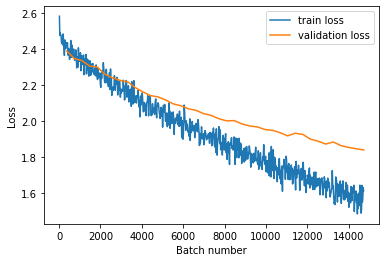

In [28]:
# Plot the outputs
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.show()

# **Examples**
Here are some images and their actual and predicted labels.

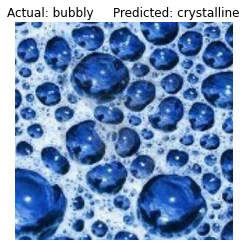

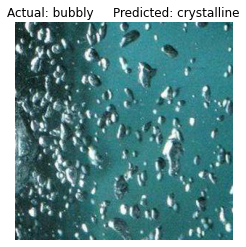

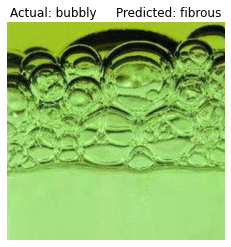

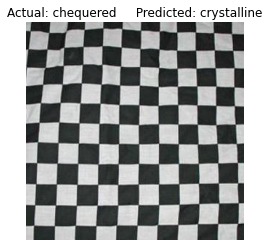

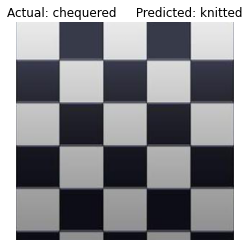

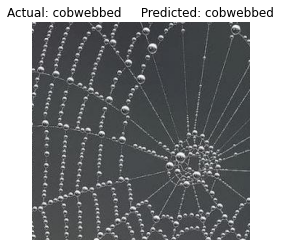

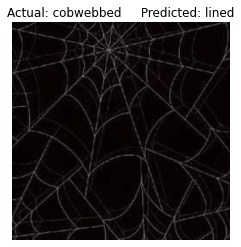

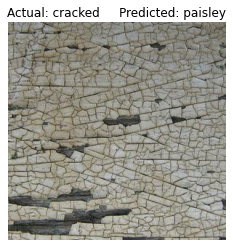

In [31]:
classes.sort()
def disp_image(image, class_idx, predicted):
    # need to reorder the tensor dimensions to work properly with imshow
    plt.imshow(image.transpose(0,2).transpose(0,1))
    plt.axis('off')
    plt.title("Actual: " + classes[class_idx] + "     Predicted: " + classes[predicted])
    plt.show()

# Santiy-check, network prediction vs ground truth label
def examine_label(idx):
    image, label = test_image_datasets[idx]
    class_scores = net(Variable(image.unsqueeze(0)).to(device))
    prediction = np.argmax(class_scores.cpu().detach().numpy())
    disp_image(image, label, prediction)

for i in range(0,500,64):
  examine_label(i)

# **Confusion matrix**
This confusion matrix highlights how well our model works on our testing set. The numbers on the main diagonal represents the number of times the model guessed a texture accurately. Our model was able to classify textures with 46.37% accuracy. If we look at the matrix carefully, we can see that the model prefers some textures over others which is the main source of innacuracy. The model often predicts some textures like fibrous, crystalline and wrinkled while it rarely predicts other textures like cracked. If we were to improve the model, we would try to get rid of this imbalance. 


Confusion matrix, without normalization
[[  8   0   6   0  16  11   2  21  13  18   1   7   0  27  14]
 [  0  12   0   0  25  11   0  19  14  13   0   1   1  31  17]
 [  1   0  32   0   5  28   0  15  15  23   0   8   0  14   3]
 [  0   0   4   0  15  31   0  12   5  60   0   2   0  12   3]
 [  1   0   2   0 341  12   0  47  59  21   0  11   1  56  20]
 [  0   0   3   0  41 381   0  47  10  27   0   0   0  44  11]
 [  0   0   7   0  29  26   3  12  17  12   0   0   0  33   5]
 [  1   0   0   0  98 114   1 219  15  16   0   7   0  92  11]
 [  0   0   0   0  60  18   0  30 384  28   0   0   0  41   4]
 [  0   0   3   0  18  48   0  26  38 368   0   0   1  52  12]
 [  1   0   1   0  33  11   0  21  28  11   4   0   1  23  10]
 [  0   0   1   0  40  17   0  33   2  22   0  16   0   9   4]
 [  0   0   1   0  25  18   0  23  16  22   0   1   0  34   4]
 [  0   0   7   0  65  34   0  41  55  54   0   4   0 293  12]
 [  2   0   0   0  37  39   0  34  60  16   0   2   1  62 316]]


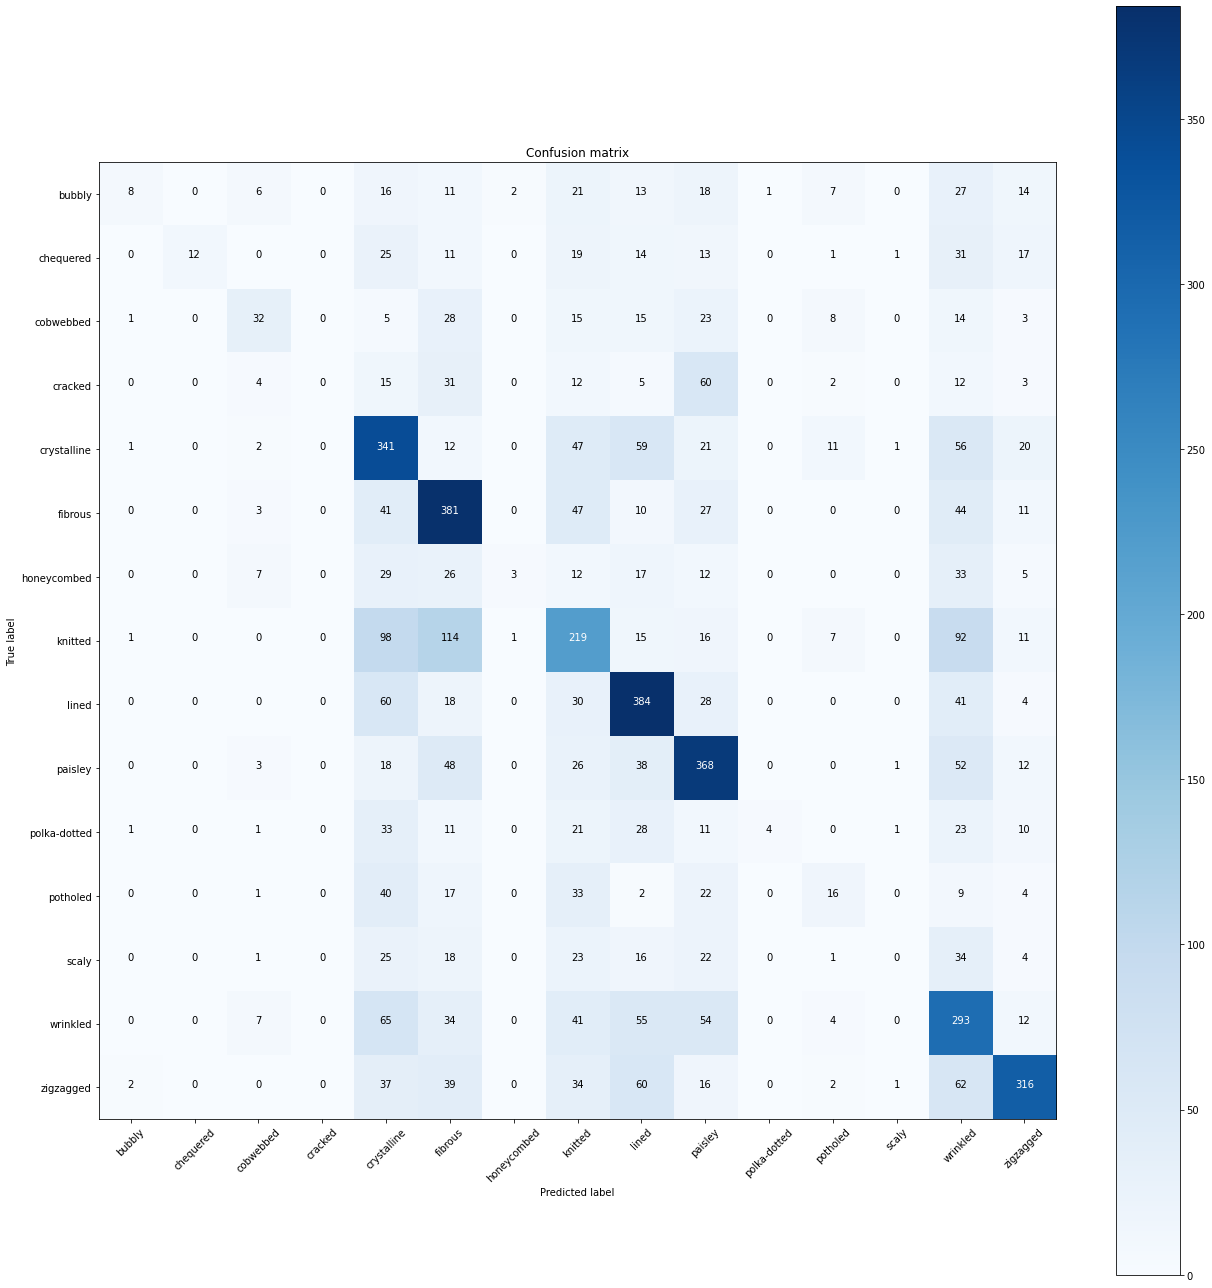

In [25]:
  from sklearn.metrics import confusion_matrix
  def make_confusion_matrix(image_dataset):
    prediction_list = []
    label_list = []
    for idx in range(len(image_dataset)):
      image, label = test_image_datasets[idx]
      class_scores = net(Variable(image.unsqueeze(0)).to(device))
      prediction = np.argmax(class_scores.cpu().detach().numpy())
      prediction_list.append(prediction)      
      label_list.append(label)
    cm = confusion_matrix(label_list, prediction_list)
    return cm

import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    f = plt.figure()
    f.set_figwidth(18)
    f.set_figheight(18)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    # disp_image(image, label, prediction)

cm = make_confusion_matrix(test_image_datasets)
plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues)

# **Accuracy**
Our model predicted textures with 46.37% accuracy on the testing data

In [26]:
# computing accuracy
def get_accuracy(net, loader):
    n_correct = 0
    n_total = 0
    for i, data in enumerate(loader, 0):
        # Get inputs in right form
        inputs, labels = data
        inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

        # Forward pass
        outputs = net(inputs)
        n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
        n_total += labels.shape[0]
    return n_correct/n_total
print("Train accuracy is", get_accuracy(net, train_loader)*100)
print("Test accuracy is", get_accuracy(net, test_loader)*100)

Train accuracy is 56.029718220530945
Test accuracy is 46.371439719079206


# **Limitations**
Our model had several limitations. One of the limitations was that some of our data was confusing because it could fall into multiple categories. For example, this image below could fall into both the category of being braided and knitted. Similarly the classes for swirly and braided were also confusing because images could fall into both of those categories. I think in general, textures are not explicitly defined subgroups and there are many things in the world that can be thought of as being multiple different textures. Because of this, we thought that the images under each class had a wide range which made it harder for our model to be accurate. 

# **References**
MIAP, C. T. B. S. H. (2019, May 27). An introduction to Convolutional Neural Networks. Medium. Retrieved October 22, 2021, from https://towardsdatascience.com/an-introduction-to-convolutional-neural-networks-eb0b60b58fd7.

Convolutional Neural Networks cheatsheet star. CS 230 - Convolutional Neural Networks Cheatsheet. (n.d.). Retrieved October 22, 2021, from https://stanford.edu/~shervine/teaching/cs-230/cheatsheet-convolutional-neural-networks. 

Brownlee, J. (2019, August 19). A gentle introduction to mini-batch gradient descent and how to configure batch size. Machine Learning Mastery. Retrieved October 22, 2021, from https://machinelearningmastery.com/gentle-introduction-mini-batch-gradient-descent-configure-batch-size/.
